# Hotel Modeling

The business problem is to forecast the demand at two hotels. In `hotel_cleaning.ipynb`, the data has been split out into train and test, with test containing the last 30 days in the dataset, and train containing all but the last 30 days. We have the number of people who have stayed at each hotel by day going back over two full years.

In reality, this does not match the exact business problem for a hotel, since bookings are usually made in advance, but it is a good use case for forecasting small datasets, something that is very difficult to do well.

## Exploration

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Set plotting defaults
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 140

In [3]:


df = pd.read_csv("../data/train.csv", parse_dates=[0], index_col=[0])
df

,Resort Hotel,City Hotel
2015-07-01,36,NaN
2015-07-02,64,NaN
2015-07-03,81,13.0
2015-07-04,108,22.0
2015-07-05,122,12.0
...,...,...
2017-08-10,178,222.0
2017-08-11,183,222.0
2017-08-12,184,225.0
2017-08-13,177,208.0


<AxesSubplot:>

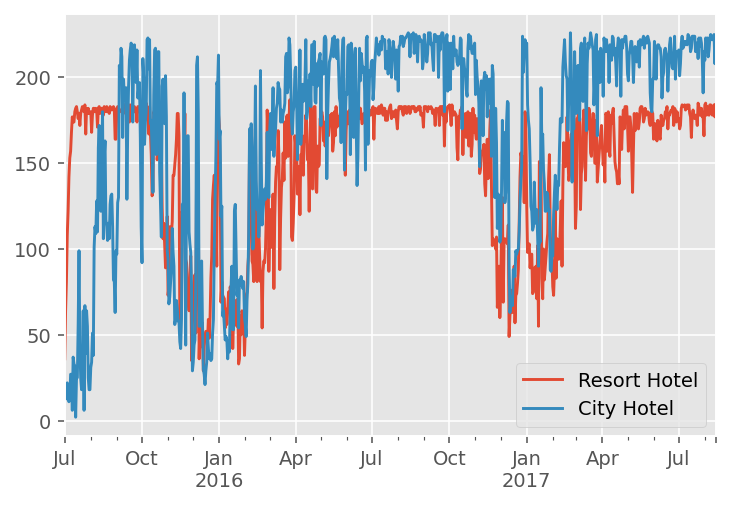

In [4]:
df.plot()

<AxesSubplot:>

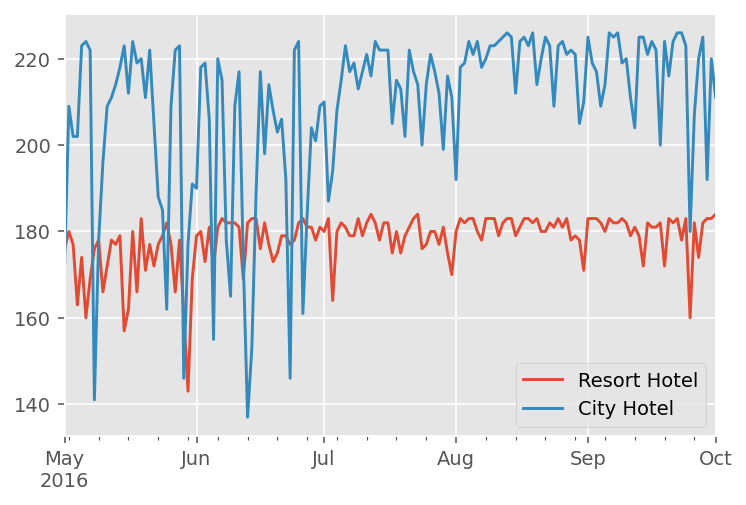

In [5]:
start_date = "2016-05-01"
end_date = "2016-10-01"
df.loc[start_date:end_date].plot()

### Observations:

1. Clear seasonality in both graphs that mostly match each other
2. The resort hotel stays close to maximum capacity throughout the summer
3. Both have spikes during holidays
4. City hotel has low volume in July and August 2015--I believe this is an artifact of how the dataset was constructed, especially given how the data looks at the same time in 2016.

## Modeling

### Approaches

This dataset poses several challenges. It might be harder for an algorithm to forecast well out of the box than for a person with a graph and a pencil. There is clear seasonality but only one prior seasonal period for the month we're trying to predict. Both datasets have a hard upper bound, which most methods will have a hard time with. There is also a lot of volatility relative to any patterns in the month we're trying to predict.

Here are the three approaches I will try:

1. Simple mean using the exact same dates from a year prior. Not very exciting, but I expect this will be a hard baseline to improve upon.
2. Same as number 1, but adjusted for weekday. There are a few ways of doing this.
3. Boosted Trees with the following configuration:
      1. We model _vacancies_ instead of rooms filled. The data becomes zero-inflated and right-skewed, and both series are more comparable
      2. Use `tweedie` loss, which is good at handling right skewed zero-inflated data
      3. Remove leap day 2016, so that `dayofyear` is directly comparable year to year
      4. Encode the following 4 features:
            1. Value exactly one year ago
            2. Mean value in the 7 day stretch centered exactly one year ago
            3. Mean value in the 31 day stretch centered exactly one year ago
            4. day of week
      5. Both hotels can be included in the same model

### Evaluation

Normally, I would say let's do walk-forward validation or hold out the last 30 days. These aren't bad approaches, but for a problem like this, I think it can easily lead to overfitting if we test one too many methods. For this problem, I prefer visually inspecting the predictions, verifying they look how I would expect them to look.

### Method 1: The Mean


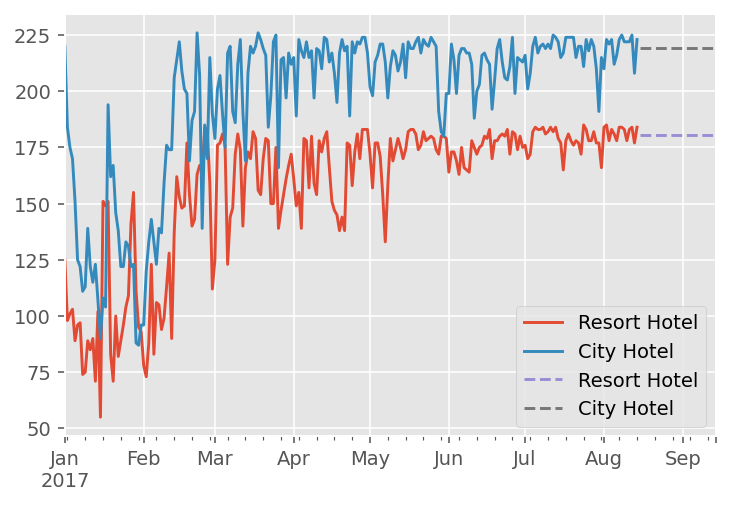

In [6]:
start_test = "2017-08-15"
end_test = "2017-09-14"

start_date = "2016-08-15"
end_date = "2016-09-14"
mean_vals = df[start_date:end_date].mean()

# Make prediction df
preds = {}
preds["mean"] = pd.DataFrame(index=pd.date_range(start_test, end_test))
for idx, val in mean_vals.iteritems():
    preds["mean"][idx] = val

# Plot it
fig, ax = plt.subplots()
df["2017-01-01":].plot(ax=ax)
preds["mean"].plot(ax=ax, ls="--")
plt.show()


### Method 3: Boosted Trees

1. Remove bogus rows
      1. Start of city hotel
      2. leap day
2. Calculate rolling 7 and 31 day means
3. Add dates onto end of df
4. Shift values to create features
5. Add day of week feature

Arbitrarily saying 2015-08-01 is start for resort, 2015-09-01 is start for city

In [7]:
df_ = df.copy()
df_.loc[df_.index < "2015-08-01", "Resort Hotel"] = np.nan
df_.loc[df_.index < "2015-10-01", "City Hotel"] = np.nan
df_ = df_.drop(index="2016-02-29")
df_

,Resort Hotel,City Hotel
2015-07-01,NaN,NaN
2015-07-02,NaN,NaN
2015-07-03,NaN,NaN
2015-07-04,NaN,NaN
2015-07-05,NaN,NaN
...,...,...
2017-08-10,178.0,222.0
2017-08-11,183.0,222.0
2017-08-12,184.0,225.0
2017-08-13,177.0,208.0


In [8]:
windows = [7, 15]
cols = list(df_.columns)
for window in windows:
    for col in cols:
        df_[f"{col}_{window}"] = df_[col].rolling(window).mean()
df_.sample(10)

,Resort Hotel,City Hotel,Resort Hotel_7,City Hotel_7,Resort Hotel_15,City Hotel_15
2015-12-17,52.0,34.0,46.428571,41.285714,69.333333,81.000000
2015-12-10,46.0,91.0,90.000000,125.571429,80.000000,94.733333
2016-05-16,162.0,212.0,170.142857,211.857143,171.200000,205.600000
2015-08-24,183.0,NaN,181.142857,NaN,181.266667,NaN
2015-09-06,180.0,NaN,178.714286,NaN,179.133333,NaN
2016-07-08,179.0,219.0,178.285714,209.000000,179.466667,205.200000
2015-09-11,182.0,NaN,181.285714,NaN,179.200000,NaN
2016-07-28,177.0,212.0,179.571429,213.571429,179.266667,214.533333
2016-07-24,176.0,200.0,179.714286,211.857143,180.133333,215.466667
2017-08-12,184.0,225.0,182.000000,222.142857,180.333333,217.333333


`df_` now contains rolling features "as of" the indexed date. These need to be joined to the right target date.

The gaps are:

* actual values: 365
* window 7: 362
* window 15: 358
<!-- * window 31: 350 -->

Might as well make the abt go too far to be safe

In [9]:

# dicts for window features
window_dict = {
    "day": ["", 365],
    "week": ["_7", 362],
    "2_week": ["_15", 358],
    # "month": ["_31", 350],
}

df_list = []
for col in cols:
    curr_abt = pd.DataFrame(index=pd.date_range(df_.index.min(), "2018-03-01"))
    
    # No leap days!
    curr_abt = curr_abt.drop(index="2016-02-29")

    # Assign actual values
    curr_abt["target"] = df_[col]
    curr_abt["hotel"] = col

    # Assign window features
    for name, values in window_dict.items():
        curr_abt[f"last_year_{name}"] = df_[f"{col}{values[0]}"]
        curr_abt[f"last_year_{name}"] = curr_abt[f"last_year_{name}"].shift(values[1])
    df_list.append(curr_abt)

# Concat and drop non-target missings
abt = pd.concat(df_list)
abt = abt.dropna(subset=[col for col in abt.columns if col != "target"])
abt["weekday"] = abt.index.weekday
print(abt.shape)
abt.sample(20)

(1081, 6)


,target,hotel,last_year_day,last_year_week,last_year_2_week,weekday
2017-02-26,183.0,Resort Hotel,121.0,123.571429,109.933333,6
2017-01-30,87.0,City Hotel,81.0,69.714286,80.600000,0
2018-02-14,NaN,City Hotel,214.0,200.000000,183.800000,2
2016-12-06,106.0,Resort Hotel,154.0,95.571429,72.266667,1
2017-12-11,NaN,City Hotel,90.0,119.857143,115.533333,0
2017-10-27,NaN,Resort Hotel,154.0,167.857143,170.733333,4
2016-12-31,174.0,Resort Hotel,179.0,135.571429,119.066667,5
2017-08-22,NaN,City Hotel,225.0,220.000000,220.800000,1
2016-10-10,159.0,Resort Hotel,183.0,166.857143,170.400000,0
2017-10-16,NaN,City Hotel,170.0,207.142857,206.200000,0


In [10]:
# Transform target
max_cap = abt.groupby("hotel", as_index=False)["target"].max()
abt["target"] = abt.groupby("hotel")["target"].transform("max") - abt.target

piv = pd.pivot_table(abt, index="target", columns="hotel", values="weekday", aggfunc="count")
piv.head(20)

hotel,City Hotel,Resort Hotel
target,,
0.0,2.0,2.0
1.0,5.0,12.0
2.0,14.0,35.0
3.0,14.0,22.0
4.0,14.0,17.0
5.0,9.0,14.0
6.0,13.0,21.0
7.0,10.0,22.0
8.0,7.0,11.0


In [11]:
from lightgbm import LGBMRegressor

abt["weekday"] = abt["weekday"].astype("category")

# Fit model
train = abt[abt.target.notna()]
pred_cols = [col for col in train.columns if col not in ["hotel", "target"]]
est = LGBMRegressor(objective="tweedie")
est.fit(train[pred_cols], train["target"])

# Make predictions
test = abt[abt.target.isna()]
y_pred_raw = est.predict(test[pred_cols])


# Back transform
test = test.drop(columns="target").reset_index().merge(max_cap, on="hotel", how="left")
test["pred"] = test.target - y_pred_raw

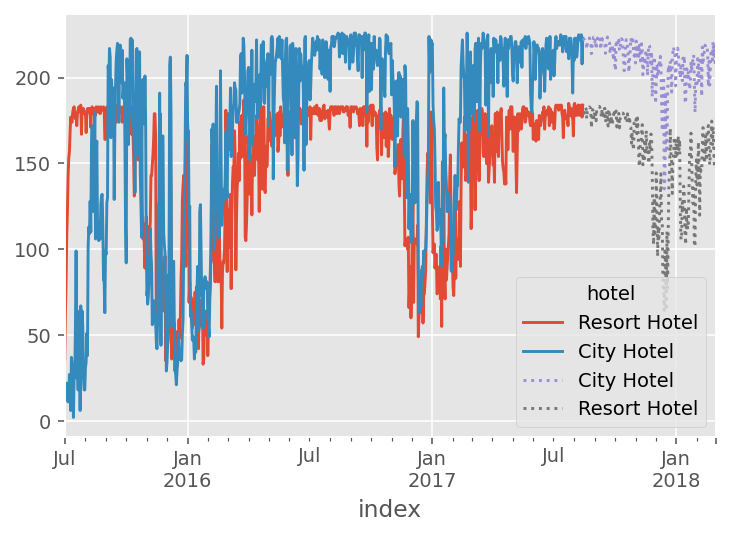

In [12]:
# Pivot predictions back out
piv = pd.pivot_table(test, index="index", columns="hotel", values="pred")

# Plot it!
fig, ax = plt.subplots()
df.plot(ax=ax)
piv.plot(ax=ax, ls=":")
plt.show()

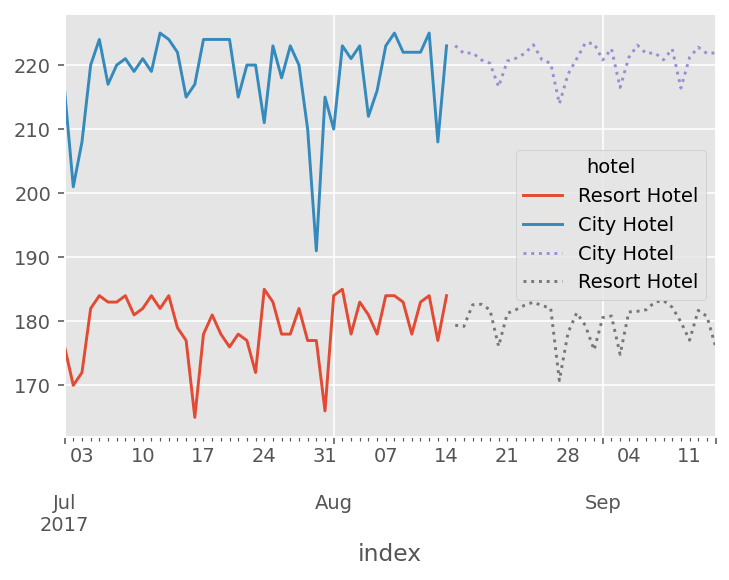

In [13]:
# Pivot predictions back out
piv = pd.pivot_table(test, index="index", columns="hotel", values="pred")

# Plot it!
fig, ax = plt.subplots()
df["2017-07-01":].plot(ax=ax)
piv[:"2017-09-14"].plot(ax=ax, ls=":")
plt.show()

<AxesSubplot:>

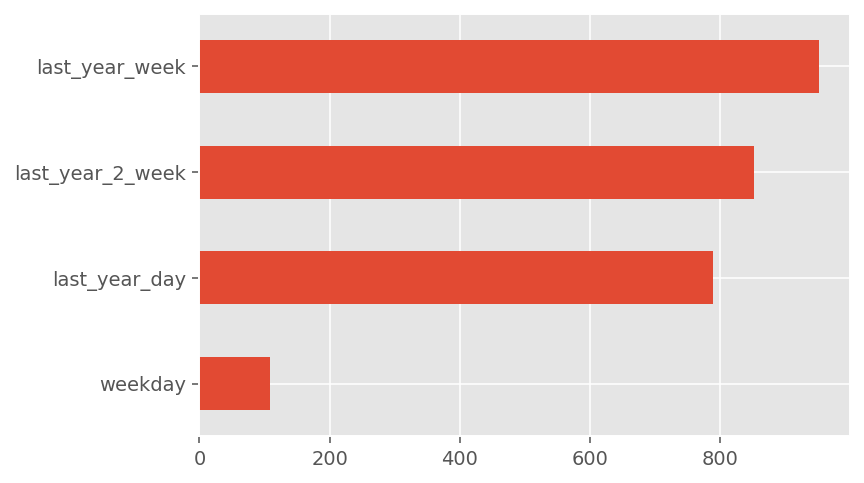

In [14]:
fi = pd.Series(est.feature_importances_, index=pred_cols)
fi.sort_values().plot.barh()

The predictions look pretty reasonable, probably similar to a method using mean and weekday information for the time period we were interested in.

## Submit predictions

In [17]:
piv[start_test:end_test].to_csv("../data/rob_hotel_preds.csv")